
<font color="#00296b"><h1>**Project Overview**</h1></font>
## **Credit Risk EDA and Feature Engineering**

>### Project Objective
The goal of this project is to perform a complete exploratory data analysis (EDA) on a credit risk dataset, identify key risk drivers, engineer predictive features, and prepare a model-ready dataset.

>### Dataset
- 8,000 loan applications
- Target: default (1 = default, 0 = paid)
- Includes demographic, financial, and credit history features

>### Key Questions
- What factors drive loan default?
- How imbalanced is the dataset?
- What features best separate defaulters?
- How should the data be prepared for modeling?



<font color="#03045e"><h1>**0. Load Data**</h1></font>


In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

In [224]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [225]:
from google.colab import files
uploaded = files.upload()

Saving credit_risk.csv to credit_risk (1).csv


In [226]:
df6 = pd.read_csv('credit_risk.csv')

In [227]:
df6

,applicant_id,age,income,employment_length,debt,credit_score,loan_amount,interest_rate,term,purpose,grade,delinquencies,inquiries,open_accounts,default
0,1,49,22504.0,0.9,8479.99,728,15692,8.18,36,credit_card,A,1.0,2,8,0
1,2,29,25587.0,6.6,6793.81,755,10267,7.77,36,home,AA,0.0,0,5,0
2,3,45,NaN,17.2,14222.01,750,11582,9.77,36,debt_consolidation,A,1.0,1,5,0
3,4,54,18076.0,3.1,1794.14,606,13400,10.82,60,car,C,2.0,0,10,1
4,5,61,16978.0,6.3,2167.07,850,57445,5.63,36,credit_card,AA,1.0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,56,32962.0,2.0,11723.48,675,2293,8.40,36,debt_consolidation,B,2.0,0,11,0
7996,7997,32,41100.0,0.3,12761.73,850,2520,3.91,60,other,AA,0.0,1,10,0
7997,7998,47,15000.0,0.0,2725.83,591,12251,16.26,60,debt_consolidation,D,0.0,1,4,1
7998,7999,41,34001.0,4.4,2787.99,568,21055,13.16,60,credit_card,D,0.0,0,8,0


In [228]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   applicant_id       8000 non-null   int64  
 1   age                8000 non-null   int64  
 2   income             7327 non-null   float64
 3   employment_length  7606 non-null   float64
 4   debt               8000 non-null   float64
 5   credit_score       8000 non-null   int64  
 6   loan_amount        8000 non-null   int64  
 7   interest_rate      8000 non-null   float64
 8   term               8000 non-null   int64  
 9   purpose            8000 non-null   object 
 10  grade              8000 non-null   object 
 11  delinquencies      7781 non-null   float64
 12  inquiries          8000 non-null   int64  
 13  open_accounts      8000 non-null   int64  
 14  default            8000 non-null   int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 937.6+ KB




<font color="#03045e"><h1>**1. Initial Data Profiling (Data Quality Report)**</h1></font>



In [233]:
print("="*70)
print("PHASE 1 - INITIAL PROFILING")
print("="*70)
print("-"*50)
print("Shape:", df6.shape)
print("\nDtypes (count):")
print(df6.dtypes.value_counts())
print("-"*50)

dup = df6.duplicated().sum()
print(f"\nDuplicate rows: {dup}")
print("-"*50)
missing = pd.DataFrame({
    "missing_count": df6.isna().sum(),
    "missing_pct": (df6.isna().mean() * 100).round(2)
}).sort_values("missing_pct", ascending=False)

missing_nonzero = missing[missing["missing_count"] > 0]
print("\nMissing values (non-zero):")
print(missing_nonzero if len(missing_nonzero) else "None")
print("-"*50)
# Target distribution
counts = df6["default"].value_counts().sort_index()
props = df6["default"].value_counts(normalize=True).sort_index()
imbalance_ratio = counts.max() / counts.min()

print("\nTarget counts:")
print(counts)
print("\nTarget proportions:")
print(props.round(4))
print("-"*50)
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}:1")

PHASE 1 - INITIAL PROFILING
--------------------------------------------------
Shape: (8000, 15)

Dtypes (count):
int64      8
float64    5
object     2
Name: count, dtype: int64
--------------------------------------------------

Duplicate rows: 0
--------------------------------------------------

Missing values (non-zero):
                   missing_count  missing_pct
income                       673         8.41
employment_length            394         4.92
delinquencies                219         2.74
--------------------------------------------------

Target counts:
default
0    6892
1    1108
Name: count, dtype: int64

Target proportions:
default
0    0.8615
1    0.1385
Name: proportion, dtype: float64
--------------------------------------------------

Imbalance ratio (majority/minority): 6.22:1


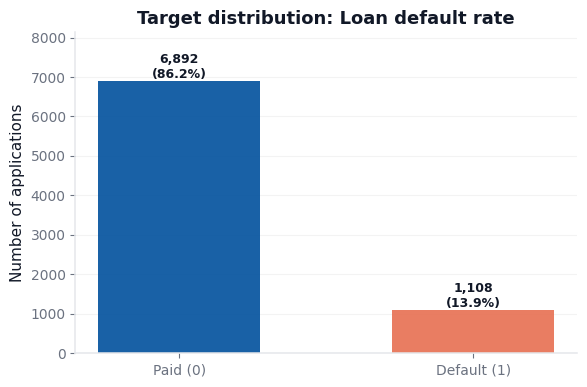

In [234]:
# --------- target chart ----------
labels = ["Paid (0)", "Default (1)"]
vals = [counts.get(0, 0), counts.get(1, 0)]

fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(
    labels,
    vals,
    color=["#00509d", "#E76F51"],
    width=0.55,
    alpha=0.9
)

ax.set_title("Target distribution: Loan default rate", loc="center", weight="bold")
ax.set_ylabel("Number of applications")

# Light grid
ax.grid(axis="y", alpha=0.15)
ax.set_axisbelow(True)

# Clean axis style
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.1)
ax.spines["bottom"].set_linewidth(1.1)

# Annotate counts + percentages
for i, b in enumerate(bars):
    v = b.get_height()
    pct = props.get(i, 0) * 100
    ax.text(
        b.get_x() + b.get_width()/2,
        v,
        f"{int(v):,}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9,
        weight="semibold"
    )

ax.set_ylim(0, max(vals) * 1.18)
plt.tight_layout()
plt.show()


In [235]:
# =========================
# PHASE 1 SUMMARY
# =========================
print("\n" + "="*70)
print("PHASE 1 - SUMMARY")
print("="*70)

print(f"1) Dataset: {df6.shape[0]} observations and {df6.shape[1]} features.")
print(f"2) Data types: {df6.dtypes.value_counts().to_dict()}.")
print(f"3) Missing values: {len(missing_nonzero)} features contain missing data.")
print(f"4) Duplicates: {dup} duplicate rows detected.")
print(f"5) Target imbalance: {counts.get(0,0)} paid vs {counts.get(1,0)} default "
      f"({imbalance_ratio:.2f}:1 ratio).")



PHASE 1 - SUMMARY
1) Dataset: 8000 observations and 15 features.
2) Data types: {dtype('int64'): 8, dtype('float64'): 5, dtype('O'): 2}.
3) Missing values: 3 features contain missing data.
4) Duplicates: 0 duplicate rows detected.
5) Target imbalance: 6892 paid vs 1108 default (6.22:1 ratio).





<font color="#03045e"><h1>**2. Univariate Analysis (Numeric + Categorical + Drop Flags)**</h1></font>




In [236]:
# =========================
# PHASE 2 SETUP
# =========================
print("="*70)
print("PHASE 2 - UNIVARIATE ANALYSIS")
print("="*70)

numeric_cols = df6.select_dtypes(include=[np.number]).columns.tolist()
if "default" in numeric_cols:
    numeric_cols.remove("default")

cat_cols = df6.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print("\n")

PHASE 2 - UNIVARIATE ANALYSIS

Numeric columns (12): ['applicant_id', 'age', 'income', 'employment_length', 'debt', 'credit_score', 'loan_amount', 'interest_rate', 'term', 'delinquencies', 'inquiries', 'open_accounts']
Categorical columns (2): ['purpose', 'grade']




In [237]:
# ==========================================================
# 2.1 NUMERIC ANALYSIS (distributions, skewness, outliers)
# ==========================================================
print("\n" + "="*70)
print("2.1 - NUMERIC ANALYSIS (Skewness + Outliers + Visuals)")
print("="*70)

# Skewness table
skew_table = (
    df6[numeric_cols]
    .skew(numeric_only=True)
    .sort_values(ascending=False)
    .to_frame("skewness")
)
display(skew_table)

print("\n")

# IQR outlier percentage
outlier_report = []
for col in numeric_cols:
    s = df6[col].dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_pct = ((s < lower) | (s > upper)).mean() * 100
    outlier_report.append((col, outlier_pct))

outlier_table = pd.DataFrame(outlier_report, columns=["feature", "outlier_pct_iqr"]).sort_values(
    "outlier_pct_iqr", ascending=False
)
display(outlier_table)


2.1 - NUMERIC ANALYSIS (Skewness + Outliers + Visuals)


,skewness
debt,2.583357
income,2.293044
loan_amount,2.283807
employment_length,1.911601
delinquencies,1.373486
inquiries,1.061234
open_accounts,0.450196
term,0.355028
age,0.153983
interest_rate,0.111376


,feature,outlier_pct_iqr
4,debt,6.675000
6,loan_amount,6.100000
2,income,5.227242
3,employment_length,4.746253
11,open_accounts,1.262500
9,delinquencies,1.195219
1,age,0.400000
7,interest_rate,0.362500
5,credit_score,0.287500
10,inquiries,0.100000



Top skewed variables plotted: ['debt', 'income', 'loan_amount', 'employment_length', 'delinquencies', 'inquiries']


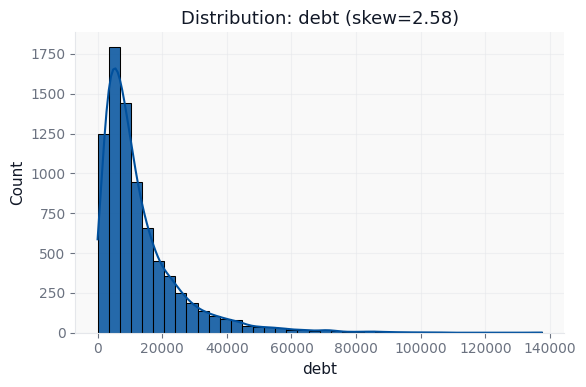

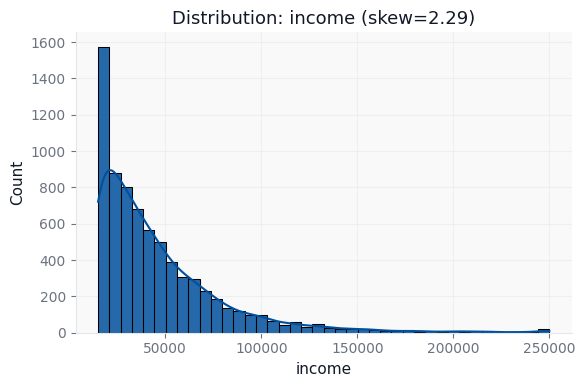

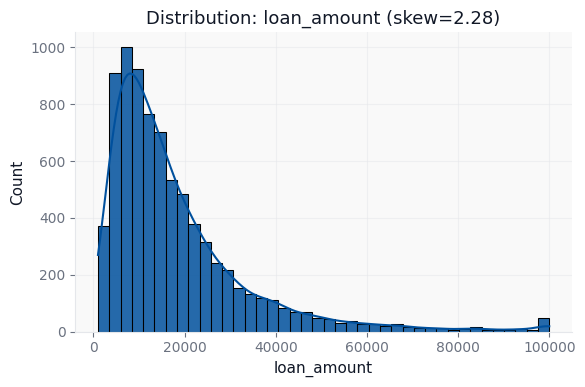

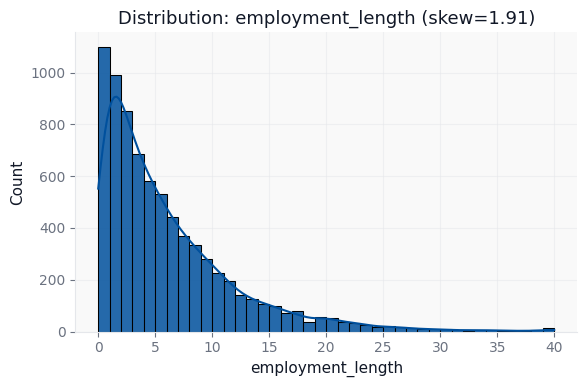

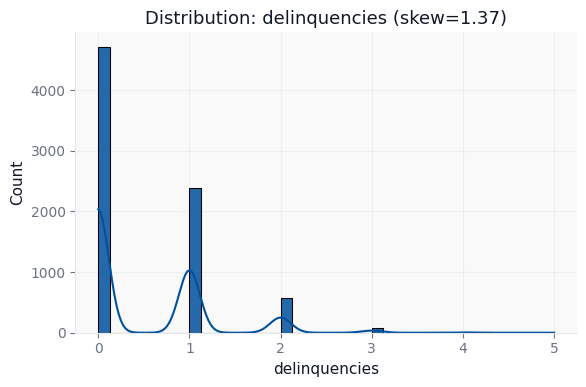

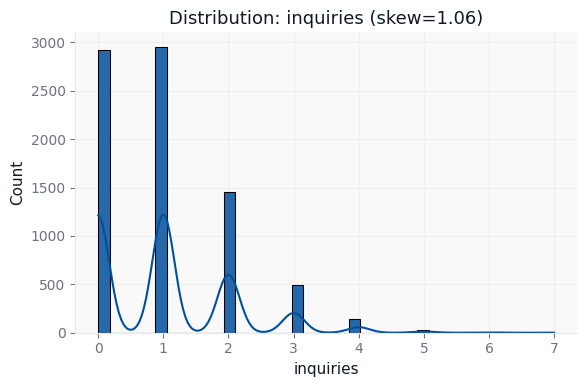

In [238]:
# Visualize top 6 skewed variables
top_skewed = skew_table.head(6).index.tolist()
print("\nTop skewed variables plotted:", top_skewed)

for col in top_skewed:
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.histplot(
        df6[col].dropna(),
        bins=40,
        kde=True,
        color="#00509d",
        edgecolor="black",
        alpha=0.85,
        ax=ax
    )

    skew_val = df6[col].dropna().skew()


    ax.set_title(f"Distribution: {col} (skew={skew_val:.2f})")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    # Light gridlines
    ax.grid(True, color=NEUTRAL, linewidth=0.8, alpha=0.5)
    ax.set_axisbelow(True)

    # Subtle background
    ax.set_facecolor("#f9f9f9")

    plt.tight_layout()
    plt.show()
    print("\n")



2.2 - CATEGORICAL ANALYSIS (Frequencies + Rare Categories)

Column: purpose
Unique categories: 5
Rare categories (<1%): 0


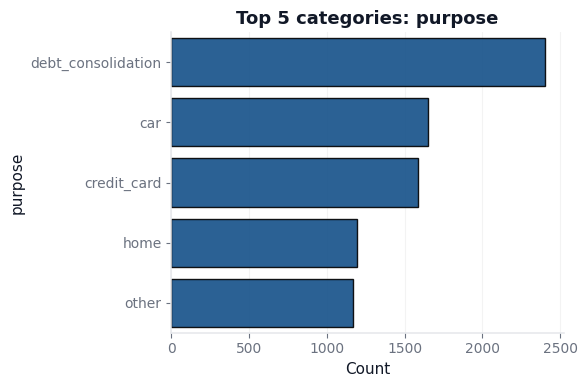


Column: grade
Unique categories: 5
Rare categories (<1%): 0


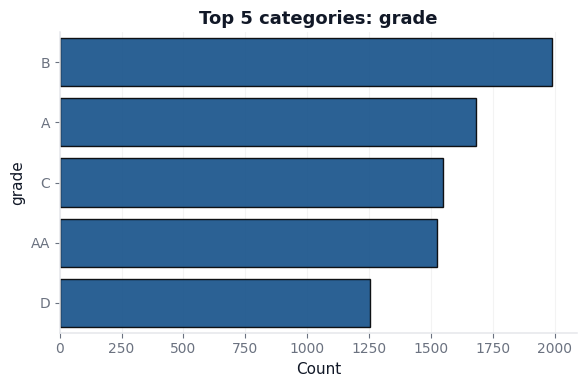




Categorical summary table:


,feature,n_unique,rare_categories_<1%
0,purpose,5,0
1,grade,5,0


In [239]:
PRIMARY = "#00509D"
NEUTRAL = "#E5E7EB"

# ==========================================================
# 2.2 CATEGORICAL ANALYSIS (frequencies, rare categories)
# ==========================================================
print("\n" + "="*70)
print("2.2 - CATEGORICAL ANALYSIS (Frequencies + Rare Categories)")
print("="*70)

rare_threshold = 0.01  # 1%
cat_summary = []

for col in cat_cols:
    vc = df6[col].value_counts(dropna=False)
    vc_norm = df6[col].value_counts(dropna=False, normalize=True)

    n_unique = df6[col].nunique(dropna=False)
    rare_count = (vc_norm < rare_threshold).sum()

    cat_summary.append((col, n_unique, rare_count))

    print(f"\nColumn: {col}")
    print(f"Unique categories: {n_unique}")
    print(f"Rare categories (<1%): {rare_count}")

    # bar chart: top categories
    top_n = min(10, len(vc))
    vc_top = vc.head(top_n)

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.barplot(
        x=vc_top.values,
        y=vc_top.index,
        color=PRIMARY,
        edgecolor="black",
        alpha=0.9,
        ax=ax
    )

    ax.set_title(f"Top {top_n} categories: {col}",
                 loc="center", weight="semibold")
    ax.set_xlabel("Count")
    ax.set_ylabel(col)

    # Subtle grid
    ax.grid(axis="x", alpha=0.15)
    ax.set_axisbelow(True)

    # Clean axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)

    plt.tight_layout()
    plt.show()

cat_summary_df6 = pd.DataFrame(
    cat_summary,
    columns=["feature", "n_unique", "rare_categories_<1%"]
).sort_values("n_unique", ascending=False)

print("\n")
print("\nCategorical summary table:")
display(cat_summary_df6)



2.3 - TRANSFORMATION FLAGS
Recommend LOG transform (skew > 1):
['debt', 'income', 'loan_amount', 'employment_length', 'delinquencies', 'inquiries']

Consider mild transform / robust scaling (0.75 < skew <= 1):
None




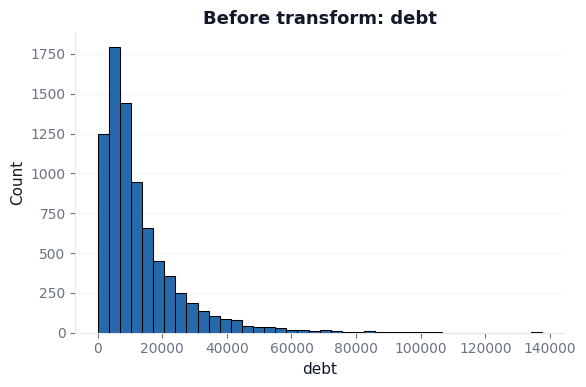

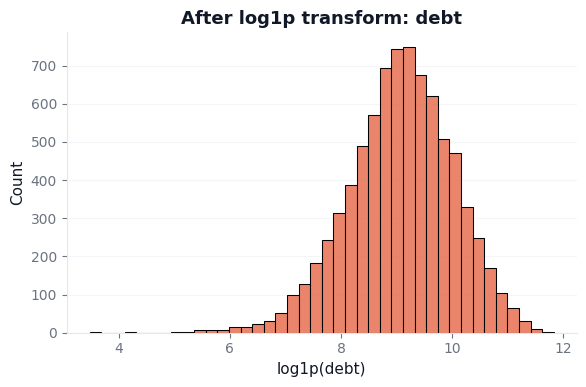

In [240]:
# ==========================================================
# 2.3 FLAG VARIABLES NEEDING TRANSFORMATION
# ==========================================================
print("\n" + "="*70)
print("2.3 - TRANSFORMATION FLAGS")
print("="*70)

# Criteria :
# - skewness > 1 => consider log transform
# - skewness between 0.75 and 1 => consider mild transform / robust scaling
transform_log = skew_table[skew_table["skewness"] > 1].index.tolist()
transform_mild = skew_table[
    (skew_table["skewness"] > 0.75) & (skew_table["skewness"] <= 1)
].index.tolist()

print("Recommend LOG transform (skew > 1):")
print(transform_log if transform_log else "None")

print("\nConsider mild transform / robust scaling (0.75 < skew <= 1):")
print(transform_mild if transform_mild else "None")

print("\n")

PRIMARY = "#00509D"
ACCENT = "#E76F51"
NEUTRAL = "#E5E7EB"

# quick before/after demo on the most skewed variable
if len(transform_log) > 0:
    demo_col = transform_log[0]

    # Before transform
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(
        df6[demo_col].dropna(),
        bins=40,
        color=PRIMARY,
        edgecolor="black",
        alpha=0.85,
        ax=ax
    )
    ax.set_title(f"Before transform: {demo_col}", loc="center", weight="semibold")
    ax.set_xlabel(demo_col)
    ax.set_ylabel("Count")

    ax.grid(axis="y", color=NEUTRAL, linewidth=0.8, alpha=0.4)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

    # After transform
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(
        np.log1p(df6[demo_col].dropna()),
        bins=40,
        color=ACCENT,
        edgecolor="black",
        alpha=0.85,
        ax=ax
    )
    ax.set_title(f"After log1p transform: {demo_col}", loc="center", weight="semibold")
    ax.set_xlabel(f"log1p({demo_col})")
    ax.set_ylabel("Count")

    ax.grid(axis="y", color=NEUTRAL, linewidth=0.8, alpha=0.4)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()



In [241]:
# ==========================================================
# 2.4 IDENTIFY VARIABLES TO DROP
# ==========================================================
print("\n" + "="*70)
print("2.4 -DROP CANDIDATES (Too Missing / Zero Variance)")
print("="*70)

missing_table = pd.DataFrame({
    "missing_count": df6.isna().sum(),
    "missing_pct": (df6.isna().mean() * 100).round(2)
}).sort_values("missing_pct", ascending=False)

# Drop rules:
# - Missing > 40%
# - Zero variance (<=1 unique non-null value)
drop_candidates = []

too_missing = missing_table[missing_table["missing_pct"] > 40].index.tolist()
drop_candidates += too_missing

for col in df6.columns:
    if df6[col].nunique(dropna=True) <= 1:
        drop_candidates.append(col)

drop_candidates = sorted(set(drop_candidates))

print("Missingness table (top):")
display(missing_table.head(10))

print("\nDrop candidates based on rules:")
print(drop_candidates if drop_candidates else "None")



2.4 -DROP CANDIDATES (Too Missing / Zero Variance)
Missingness table (top):


,missing_count,missing_pct
income,673,8.41
employment_length,394,4.92
delinquencies,219,2.74
age,0,0.00
debt,0,0.00
credit_score,0,0.00
applicant_id,0,0.00
loan_amount,0,0.00
interest_rate,0,0.00
purpose,0,0.00



Drop candidates based on rules:
None


In [242]:
# =========================
# PHASE 2 SUMMARY
# =========================
print("\n" + "="*70)
print("PHASE 2 - SUMMARY")
print("="*70)

print(f"1) Numeric: {len(numeric_cols)} numeric features reviewed; top skewed features include {top_skewed}.")
print(f"2) Categorical: {len(cat_cols)} categorical features reviewed; rare categories flagged where applicable.")
print(f"3) Transformations: {len(transform_log)} features recommended for log transform; {len(transform_mild)} for mild handling.")
print(f"4) Drop: {len(drop_candidates)} features recommended for removal based on missingness/variance rules.")


PHASE 2 - SUMMARY
1) Numeric: 12 numeric features reviewed; top skewed features include ['debt', 'income', 'loan_amount', 'employment_length', 'delinquencies', 'inquiries'].
2) Categorical: 2 categorical features reviewed; rare categories flagged where applicable.
3) Transformations: 6 features recommended for log transform; 0 for mild handling.
4) Drop: 0 features recommended for removal based on missingness/variance rules.



<font color="#03045e"><h1>**3. Target-Related Analysis (Correlation + Boxplots + Leakage Check)**</h1></font>




PHASE 3 - TARGET-RELATED ANALYSIS

Correlation of numeric features with target (sorted by strength):


,default
credit_score,-0.231954
interest_rate,0.177053
debt,0.076360
inquiries,0.072252
employment_length,-0.070066
delinquencies,0.039725
applicant_id,-0.009183
term,-0.008224
income,-0.007310
age,0.004032


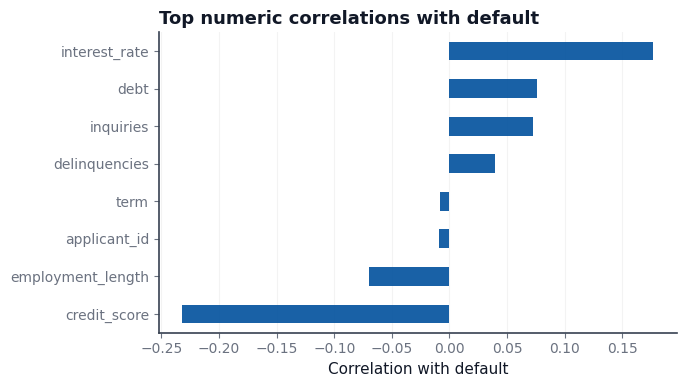

In [243]:
print("="*70)
print("PHASE 3 - TARGET-RELATED ANALYSIS")
print("="*70)

PRIMARY = "#00509D"
NEUTRAL = "#E5E7EB"
AXIS = "#374151"

# ==============================
# 3.1 Correlation with target
# ==============================
numeric_cols = df6.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("default")

corr_target = (
    df6[numeric_cols + ["default"]]
    .corr(numeric_only=True)["default"]
    .drop("default")
)

# Sort by absolute strength
corr_target_sorted = corr_target.reindex(
    corr_target.abs().sort_values(ascending=False).index
)

print("\nCorrelation of numeric features with target (sorted by strength):")
display(corr_target_sorted)

# bar chart
top_corr = corr_target_sorted.head(8)

fig, ax = plt.subplots(figsize=(7, 4))
top_corr.sort_values().plot(kind="barh", color=PRIMARY, alpha=0.9, ax=ax)

ax.set_title("Top numeric correlations with default", loc="left", weight="bold")
ax.set_xlabel("Correlation with default")

# Subtle grid
ax.grid(axis="x", alpha=0.15)
ax.set_axisbelow(True)

# Clear axis lines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(AXIS)
ax.spines["bottom"].set_color(AXIS)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

plt.tight_layout()
plt.show()



Top features selected for boxplots: ['credit_score', 'interest_rate', 'debt', 'inquiries']


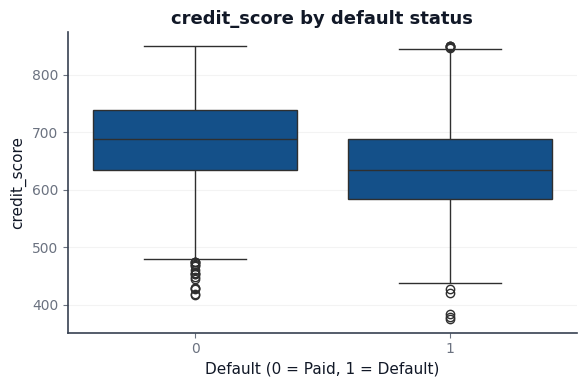

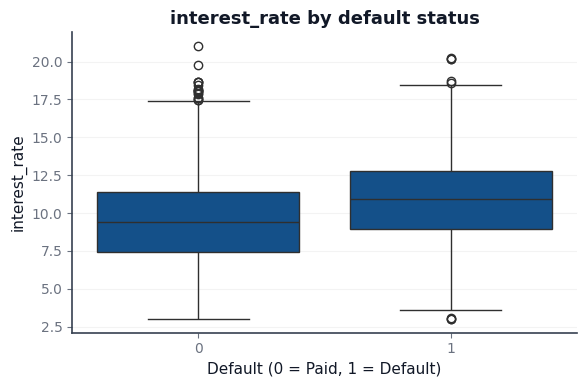

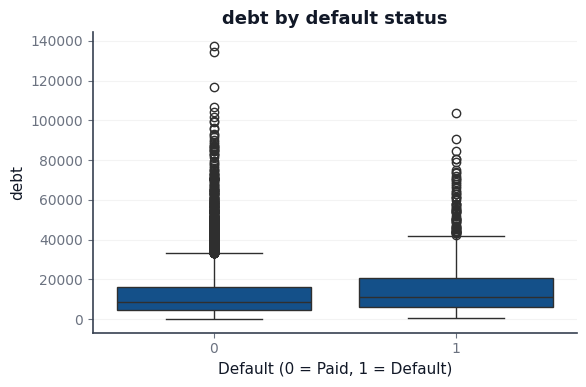

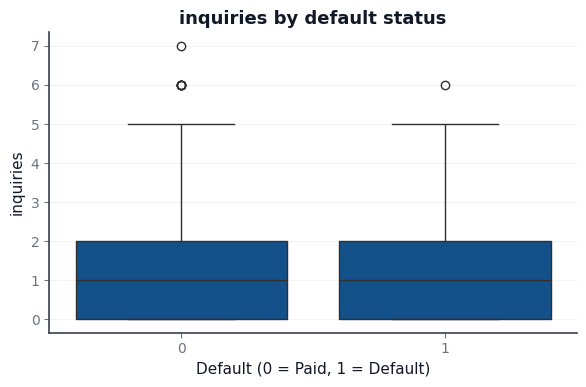

In [244]:
# ==============================
# 3.2 Boxplots: defaulters vs non-defaulters
# ==============================
PRIMARY = "#00509D"
NEUTRAL = "#E5E7EB"
AXIS = "#374151"

top_features = corr_target_sorted.head(4).index.tolist()
print("\nTop features selected for boxplots:", top_features)

for col in top_features:
    plt.figure(figsize=(6,4))
    ax = plt.gca()

    sns.boxplot(
        x="default",
        y=col,
        data=df6,
        color=PRIMARY,
        ax=ax
    )

    ax.set_title(f"{col} by default status", loc="center", weight="semibold")
    ax.set_xlabel("Default (0 = Paid, 1 = Default)")
    ax.set_ylabel(col)

    # Subtle grid
    ax.grid(axis="y", alpha=0.15)
    ax.set_axisbelow(True)

    # Clear axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(AXIS)
    ax.spines["bottom"].set_color(AXIS)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)


    plt.tight_layout()
    plt.show()
    print("\n")



In [245]:
# ==============================
# 3.3 Identify best separating features
# ==============================
print("\nTop features by absolute correlation:")

top_separators = corr_target_sorted.abs().head(5)
display(top_separators)



Top features by absolute correlation:


,default
credit_score,0.231954
interest_rate,0.177053
debt,0.076360
inquiries,0.072252
employment_length,0.070066


In [246]:
# ==============================
# 3.4 Data leakage check
# ==============================
# Rule: correlation > 0.8 with target is suspicious
leakage_candidates = corr_target_sorted[
    corr_target_sorted.abs() > 0.8
]

print("\nPotential leakage features (|corr| > 0.8):")
print(leakage_candidates if len(leakage_candidates) else "None detected")



Potential leakage features (|corr| > 0.8):
None detected


In [247]:
# Executive-style summary
print("\n" + "="*70)
print("PHASE 3 - SUMMARY")
print("="*70)

print("Top predictors of default (by correlation):")
for feat, val in corr_target_sorted.head(5).items():
    print(f"- {feat}: correlation = {val:.3f}")

if len(leakage_candidates) == 0:
    print("\nNo obvious data leakage detected.")
else:
    print("\nPotential leakage detected in:")
    print(leakage_candidates.index.tolist())


PHASE 3 - SUMMARY
Top predictors of default (by correlation):
- credit_score: correlation = -0.232
- interest_rate: correlation = 0.177
- debt: correlation = 0.076
- inquiries: correlation = 0.072
- employment_length: correlation = -0.070

No obvious data leakage detected.



<font color="#03045e"><h1>**4. Bivariate Analysis (Heatmap + Multicollinearity + Pairplot)**</h1></font>





PHASE 4 - BIVARIATE ANALYSIS

4.1 Correlation Heatmap


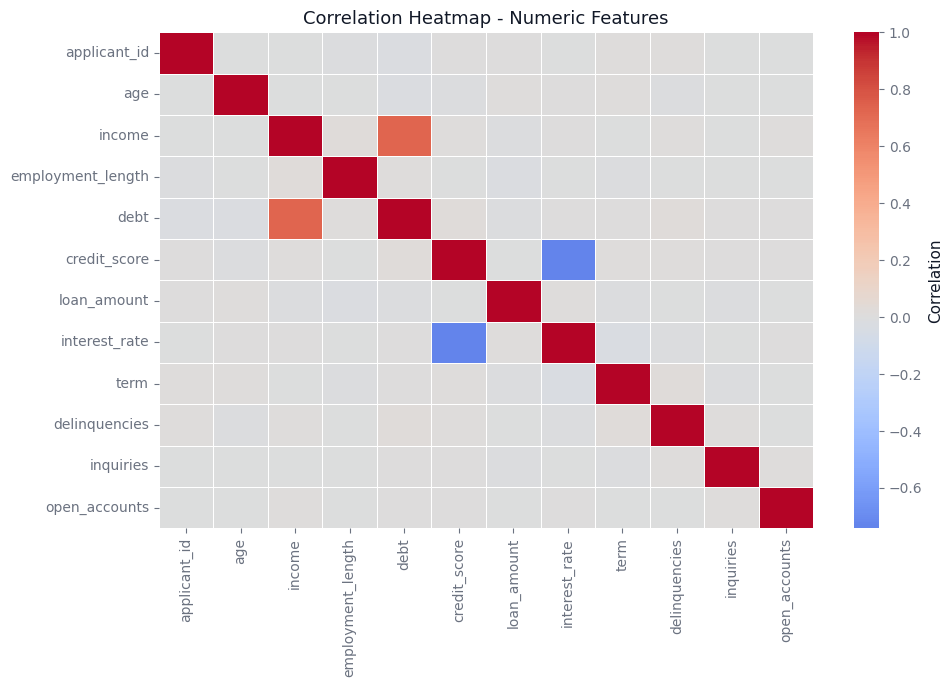

In [248]:
print("="*70)
print("PHASE 4 - BIVARIATE ANALYSIS")
print("="*70)

ACCENT = "#1f77b4"

# Numeric columns
numeric_cols = df6.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("default")

# ======================================================
# 4.1 Correlation Heatmap
# ======================================================
print("\n4.1 Correlation Heatmap")

corr_matrix = df6[numeric_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Heatmap - Numeric Features")
plt.tight_layout()
plt.show()

In [249]:
# ======================================================
# 4.2 Multicollinearity Detection
# ======================================================
print("\n4.2 Multicollinearity Check (|corr| > 0.85)")

high_corr_pairs = []
threshold = 0.85
cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_val))

high_corr_df6 = pd.DataFrame(
    high_corr_pairs,
    columns=["feature_1", "feature_2", "correlation"]
).sort_values("correlation", key=lambda s: s.abs(), ascending=False)

if len(high_corr_df6) == 0:
    print("No strong multicollinearity detected.")
else:
    display(high_corr_df6)


4.2 Multicollinearity Check (|corr| > 0.85)
No strong multicollinearity detected.



4.3 Non-linear Relationship Inspection


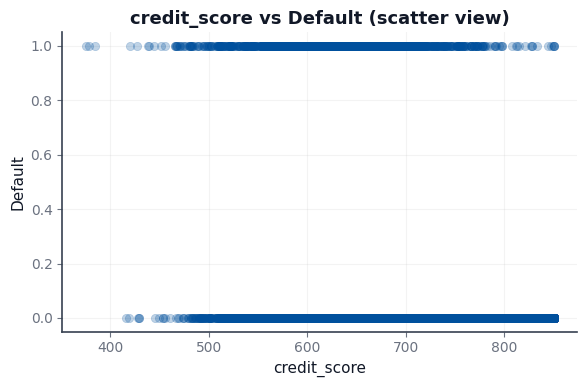

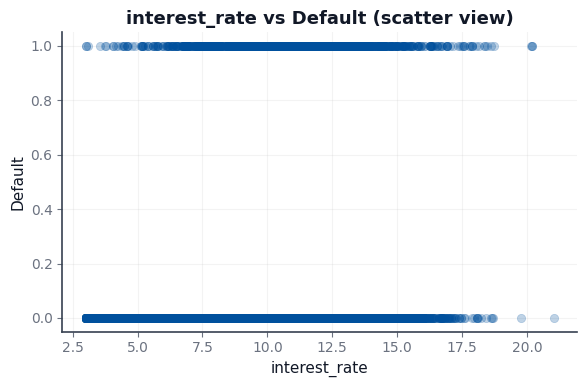

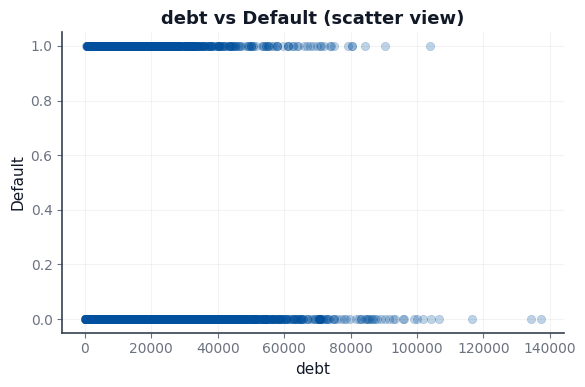

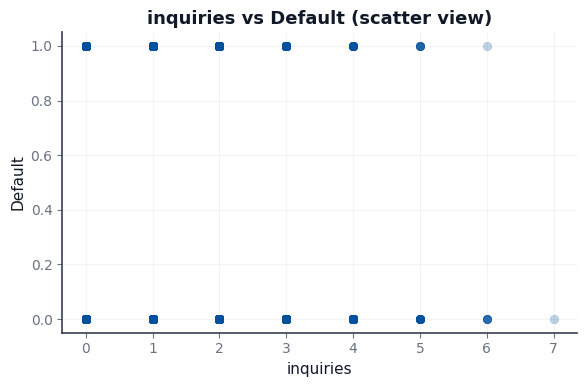

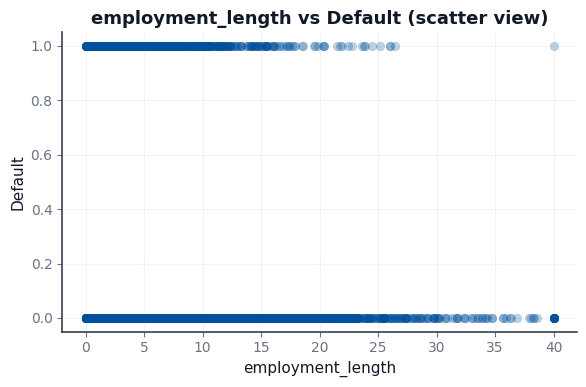

In [250]:
# ======================================================
# 4.3 Non-linear Relationship Check
# (scatter with target overlay)
# ======================================================
print("\n4.3 Non-linear Relationship Inspection")

PRIMARY = "#00509D"
NEUTRAL = "#E5E7EB"
AXIS = "#374151"

top_features = ["credit_score", "interest_rate", "debt", "inquiries", "employment_length"]

for col in top_features:
    plt.figure(figsize=(6,4))
    ax = plt.gca()

    sns.scatterplot(
        x=df6[col],
        y=df6["default"],
        alpha=0.25,
        color=PRIMARY,
        edgecolor=None,
        ax=ax
    )

    ax.set_title(f"{col} vs Default (scatter view)", loc="center", weight="semibold")
    ax.set_xlabel(col)
    ax.set_ylabel("Default")

    # Subtle grid
    ax.grid(axis="both", alpha=0.15)
    ax.set_axisbelow(True)

    # Clear axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(AXIS)
    ax.spines["bottom"].set_color(AXIS)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    plt.tight_layout()
    plt.show()
    print("\n")



4.4 Pair Plot of Top 5 Predictors


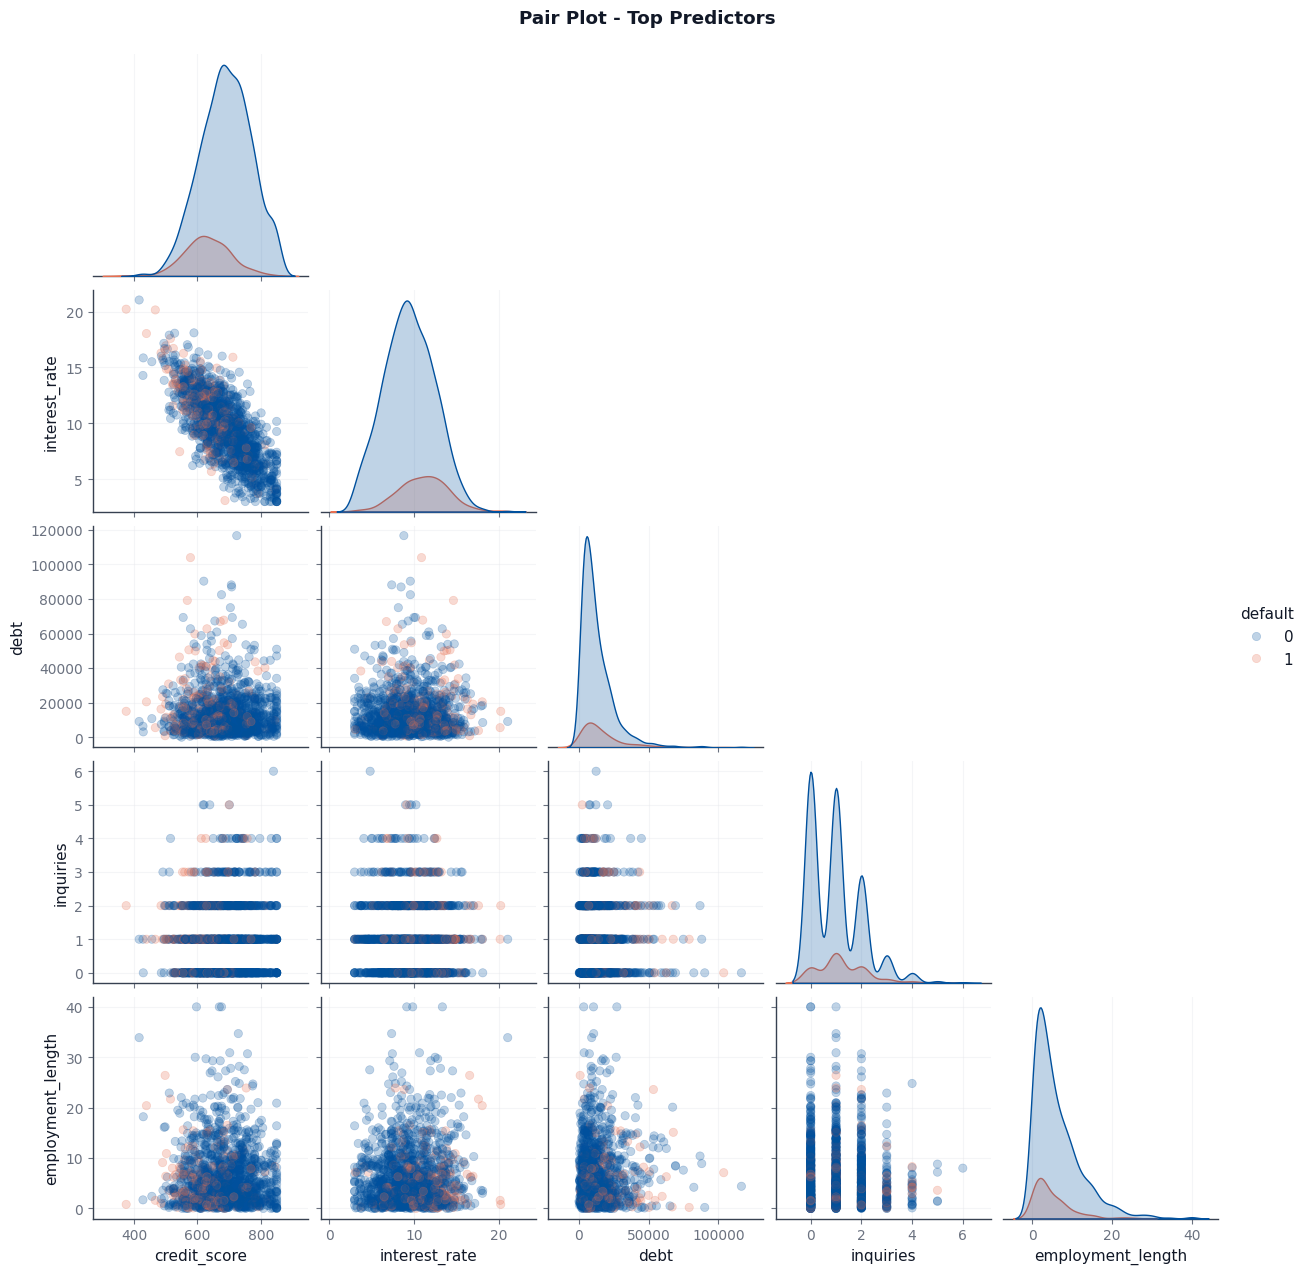

In [251]:
# ======================================================
# 4.4 Pair Plot of Top 5 Features
# ======================================================
print("\n4.4 Pair Plot of Top 5 Predictors")

PRIMARY = "#00509D"
ACCENT  = "#E76F51"
NEUTRAL = "#E5E7EB"
AXIS    = "#374151"

pair_data = df6[top_features + ["default"]].dropna()
pair_data = pair_data.sample(min(1500, len(pair_data)), random_state=42)

g = sns.pairplot(
    pair_data,
    vars=top_features,
    hue="default",
    corner=True,
    palette={0: PRIMARY, 1: ACCENT},
    plot_kws={"alpha": 0.25, "edgecolor": None}
)

# Add light gridlines + clear axes to each subplot
for ax in g.axes.flatten():
    if ax is not None:
        ax.grid(True, color=NEUTRAL, linewidth=0.8, alpha=0.4)
        ax.set_axisbelow(True)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(AXIS)
        ax.spines["bottom"].set_color(AXIS)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

plt.suptitle("Pair Plot - Top Predictors", y=1.02, weight="bold")
plt.show()


In [252]:
# ======================================================
# PHASE 4 SUMMARY
# ======================================================
print("\n" + "="*70)
print("PHASE 4 - SUMMARY")
print("="*70)

if len(high_corr_df6) == 0:
    print("• No significant multicollinearity detected among numeric features.")
else:
    print("• Multicollinearity detected between the following features:")
    display(high_corr_df6)

print("• Credit risk appears to be driven by multiple moderately correlated variables.")
print("• Non-linear patterns observed in credit_score and debt suggest benefit from")
print("  transformations or tree-based models.")


PHASE 4 - SUMMARY
• No significant multicollinearity detected among numeric features.
• Credit risk appears to be driven by multiple moderately correlated variables.
• Non-linear patterns observed in credit_score and debt suggest benefit from
  transformations or tree-based models.




<font color="#03045e"><h1>**5. Feature Engineering (Driven by EDA)**</h1></font>





In [253]:
print("="*70)
print("PHASE 5 — FEATURE ENGINEERING")
print("="*70)

df6_engineered = df6.copy()

new_features = []

# ======================================================
# 5.1 Log Transformations (from Phase 2 skewness)
# ======================================================
log_vars = [
    "debt",
    "income",
    "loan_amount",
    "employment_length",
    "delinquencies",
    "inquiries"
]

print("\nLog-transforming skewed variables:")

for col in log_vars:
    if col in df6_engineered.columns:
        new_col = f"{col}_log"
        df6_engineered[new_col] = np.log1p(df6_engineered[col])
        new_features.append(new_col)
        print(f"Created: {new_col}")


PHASE 5 — FEATURE ENGINEERING

Log-transforming skewed variables:
Created: debt_log
Created: income_log
Created: loan_amount_log
Created: employment_length_log
Created: delinquencies_log
Created: inquiries_log


In [254]:
# ======================================================
# 5.2 Debt-to-Income Ratio
# ======================================================
if "debt" in df6_engineered.columns and "income" in df6_engineered.columns:
    df6_engineered["debt_to_income"] = df6_engineered["debt"] / df6_engineered["income"]
    new_features.append("debt_to_income")
    print("\nCreated: debt_to_income")


Created: debt_to_income


In [255]:
# ======================================================
# 5.3 Missing Value Indicators
# ======================================================
missing_cols = ["income", "employment_length", "delinquencies"]

print("\nCreating missing indicators:")

for col in missing_cols:
    if col in df6_engineered.columns:
        new_col = f"{col}_missing"
        df6_engineered[new_col] = df6_engineered[col].isna().astype(int)
        new_features.append(new_col)
        print(f"Created: {new_col}")


Creating missing indicators:
Created: income_missing
Created: employment_length_missing
Created: delinquencies_missing


In [256]:
# ======================================================
# 5.4 Interaction Terms (based on Phase 3 & 4 insights)
# ======================================================
print("\nCreating interaction terms:")

interaction_pairs = [
    ("credit_score", "interest_rate"),
    ("debt", "income"),
    ("inquiries", "employment_length")
]

for col1, col2 in interaction_pairs:
    if col1 in df6_engineered.columns and col2 in df6_engineered.columns:
        new_col = f"{col1}_x_{col2}"
        df6_engineered[new_col] = df6_engineered[col1] * df6_engineered[col2]
        new_features.append(new_col)
        print(f"Created: {new_col}")


Creating interaction terms:
Created: credit_score_x_interest_rate
Created: debt_x_income
Created: inquiries_x_employment_length


In [257]:
# ======================================================
# 5.5 Binned Variables (non-linear patterns)
# ======================================================
print("\nCreating binned variables:")

# Credit score bins
if "credit_score" in df6_engineered.columns:
    df6_engineered["credit_score_bin"] = pd.cut(
        df6_engineered["credit_score"],
        bins=[300, 580, 670, 740, 800, 900],
        labels=["Poor", "Fair", "Good", "Very Good", "Excellent"]
    )
    new_features.append("credit_score_bin")
    print("Created: credit_score_bin")

# Employment length bins
if "employment_length" in df6_engineered.columns:
    df6_engineered["employment_length_bin"] = pd.cut(
        df6_engineered["employment_length"],
        bins=[-1, 1, 5, 10, 20, 50],
        labels=["<1yr", "1-5yr", "5-10yr", "10-20yr", "20+yr"]
    )
    new_features.append("employment_length_bin")
    print("Created: employment_length_bin")


Creating binned variables:
Created: credit_score_bin
Created: employment_length_bin


In [258]:
# ======================================================
# Phase 5 Summary
# ======================================================
print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"Original features: {len(df6.columns)}")
print(f"Engineered features: {len(df6_engineered.columns)}")
print(f"New features created: {len(new_features)}")

print("\nList of engineered features:")
for feat in new_features:
    print("-", feat)


FEATURE ENGINEERING SUMMARY
Original features: 15
Engineered features: 30
New features created: 15

List of engineered features:
- debt_log
- income_log
- loan_amount_log
- employment_length_log
- delinquencies_log
- inquiries_log
- debt_to_income
- income_missing
- employment_length_missing
- delinquencies_missing
- credit_score_x_interest_rate
- debt_x_income
- inquiries_x_employment_length
- credit_score_bin
- employment_length_bin




<font color="#03045e"><h1>**6. Final Dataset Preparation**</h1></font>





In [259]:
print("="*70)
print("PHASE 6 - FINAL DATASET PREPARATION")
print("="*70)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df6_model = df6_engineered.copy()

# ======================================================
# 6.1 Handle Missing Values
# Strategy:
# - Median imputation for numeric (robust to outliers)
# ======================================================
print("\n6.1 Missing Value Imputation (Median Strategy)")

numeric_cols = df6_model.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    if df6_model[col].isna().sum() > 0:
        median_val = df6_model[col].median()
        df6_model[col] = df6_model[col].fillna(median_val)
        print(f"Imputed {col} with median: {median_val:.2f}")

PHASE 6 - FINAL DATASET PREPARATION

6.1 Missing Value Imputation (Median Strategy)
Imputed income with median: 35964.00
Imputed employment_length with median: 4.20
Imputed delinquencies with median: 0.00
Imputed income_log with median: 10.49
Imputed employment_length_log with median: 1.65
Imputed delinquencies_log with median: 0.00
Imputed debt_to_income with median: 0.27
Imputed debt_x_income with median: 314339214.04
Imputed inquiries_x_employment_length with median: 1.90


In [260]:

# ======================================================
# 6.2 Handle Outliers
# Strategy:
# - Cap extreme values using IQR method
# - Keeps data but limits extreme influence
# ======================================================
print("\n6.2 Outlier Handling (IQR Capping)")

outlier_cols = [
    "debt", "income", "loan_amount",
    "debt_log", "income_log", "loan_amount_log"
]

for col in outlier_cols:
    if col in df6_model.columns:
        q1 = df6_model[col].quantile(0.25)
        q3 = df6_model[col].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df6_model[col] = np.clip(df6_model[col], lower, upper)
        print(f"Capped outliers in {col}")


6.2 Outlier Handling (IQR Capping)
Capped outliers in debt
Capped outliers in income
Capped outliers in loan_amount
Capped outliers in debt_log
Capped outliers in income_log
Capped outliers in loan_amount_log


In [261]:
# ======================================================
# 6.3 Encode Categorical Variables
# Strategy:
# - One-hot encoding
# - drop_first=True to avoid multicollinearity
# ======================================================
print("\n6.3 One-Hot Encoding Categorical Variables")

cat_cols = df6_model.select_dtypes(exclude=[np.number]).columns.tolist()

df6_model = pd.get_dummies(df6_model, columns=cat_cols, drop_first=True)

print(f"Encoded categorical columns: {cat_cols}")


6.3 One-Hot Encoding Categorical Variables
Encoded categorical columns: ['purpose', 'grade', 'credit_score_bin', 'employment_length_bin']


In [262]:
# ======================================================
# 6.4 Train/Test Split (Stratified)
# ======================================================
print("\n6.4 Train/Test Split (Stratified by target)")

X = df6_model.drop("default", axis=1)
y = df6_model["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


6.4 Train/Test Split (Stratified by target)
X_train shape: (6400, 41)
X_test shape: (1600, 41)


In [263]:
# ======================================================
# 6.5 Scale Numeric Features
# Strategy:
# - StandardScaler
# - Fit on training only
# ======================================================
print("\n6.5 Feature Scaling (StandardScaler)")

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Scaling complete.")


6.5 Feature Scaling (StandardScaler)
Scaling complete.


In [264]:
# ======================================================
# 6.6 Save Processed Dataset
# ======================================================
print("\n6.6 Saving Processed Datasets")

X_train_scaled.to_csv("X_train_processed.csv", index=False)
X_test_scaled.to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Files saved:")
print("- X_train_processed.csv")
print("- X_test_processed.csv")
print("- y_train.csv")
print("- y_test.csv")



6.6 Saving Processed Datasets
Files saved:
- X_train_processed.csv
- X_test_processed.csv
- y_train.csv
- y_test.csv


In [265]:
# ======================================================
# Phase 6 Summary
# ======================================================
print("\n" + "="*70)
print("PHASE 6 SUMMARY")
print("="*70)

print("Missing values: Median imputation")
print("Outliers: IQR-based capping")
print("Categoricals: One-hot encoding")
print("Scaling: StandardScaler")
print("Split: 80/20 stratified")


PHASE 6 SUMMARY
Missing values: Median imputation
Outliers: IQR-based capping
Categoricals: One-hot encoding
Scaling: StandardScaler
Split: 80/20 stratified


<font color="#03045e"><h1>**7. Comprehensive Report**</h1></font>



<font color="#1f7a8c"><h2>**Executive Summar**</h2></font>



> The credit risk dataset contains 8,000 loan applications with demographic, financial, and credit history features. The target variable, default, shows a significant class imbalance, with approximately 86% non-defaulters and 14% defaulters. This imbalance must be addressed during model training and evaluation.



> Univariate analysis revealed strong right-skewness in several financial variables, including debt, income, and loan amount, indicating the presence of extreme values. Log transformations were applied to stabilize these distributions. Categorical variables showed balanced distributions with no rare categories, so no grouping or removal was required.



> Target-related analysis identified credit score and interest rate as the most influential predictors of default, followed by debt levels, credit inquiries, and employment length. Bivariate analysis showed no severe multicollinearity, but several non-linear relationships were observed, suggesting the benefit of feature transformations and tree-based models.


> Feature engineering added 15 new variables, including log transformations, ratio features, interaction terms, and binned variables, expanding the dataset from 15 to 30 features. The final dataset was prepared using median imputation, outlier capping, one-hot encoding, and standardized scaling, with a stratified train-test split.






<font color="#1f7a8c"><h2>**Five Most Important Visualizations**</h2></font>

>### 1. Target Distribution (Class Imbalance)

**Insight**
- 86% paid vs 14% default
- Strong class imbalance present

**Business implication**
- Default cases are rare but critical
- False negatives are costly
- Requires imbalance-aware modeling

<br>


> ### 2. Credit Score vs Default (Box Plot)

**Insight**
- Clear separation between defaulters and non-defaulters
- Lower scores strongly linked to default

**Business implication**
- Primary risk indicator
- Key underwriting variable


<br>


> ### 3. Interest Rate vs Default (Box Plot)

**Insight**
- Defaulters tend to have higher interest rates
- Distribution shifts upward for defaulters

**Business implication**
- Reflects borrower risk level
- Strong predictive feature

<br>


> ### 4. Debt Distribution (Before vs After Log Transform)

**Insight**
- Original data heavily right-skewed
- Log transformation normalizes the distribution

**Business implication**
- Improves model stability
- Reduces impact of extreme borrowers

<br>



> ### 5. Correlation Heatmap

**Insight**
- No severe multicollinearity detected
- Strongest relationships:
  - income ↔ debt
  - credit_score ↔ interest_rate

**Business implication**
- Credit risk driven by multiple factors
- All variables can be retained

<br><br>



<font color="#bfdbf7"><h2>**Feature Engineering Justification**</h2></font>

A total of **15 engineered features** were created based on EDA findings.



>### 1. Log Transformations

**Applied to:**
- debt
- income
- loan_amount
- employment_length
- delinquencies
- inquiries

**Reason:**
- Reduce skewness
- Stabilize variance
- Improve model performance

<br>

>### 2. Ratio Feature

**Feature created:**
- `debt_to_income = debt / income`

**Reason:**
- Measures borrower financial stress
- Standard and widely used credit risk metric
<br>

>### 3. Missing Value Indicators

**Features created:**
- income_missing
- employment_length_missing
- delinquencies_missing

**Reason:**
- Missing financial data may signal higher risk
- Preserves information instead of discarding rows

<br>

>### 4. Interaction Terms

**Features created:**
- credit_score × interest_rate
- debt × income
- inquiries × employment_length

**Reason:**
- Captures combined effects of risk factors
- Reflects real-world credit behavior
<br>


>### 5. Binned Variables

**Features created:**
- credit_score_bin
- employment_length_bin

**Reason:**
- Captures non-linear risk thresholds
- Improves interpretability
- Useful for tree-based and linear models

<br><br>



<font color="#1f7a8c"><h2> **Recommended Modeling Approach**</h2></font>

>### 1. Algorithm Suggestions

**Primary models:**
- Logistic Regression (baseline, interpretable)
- Random Forest
- Gradient Boosting (XGBoost or LightGBM)

**Reason for tree-based models:**
- Data shows non-linear relationships
- Interaction effects are present
- Handles mixed feature types well

<br>

>### 2. Handling Class Imbalance

**Recommended techniques:**
- Class-weighted models
- SMOTE or undersampling (if needed)
- Stratified cross-validation

<br>

>### 3. Cross-Validation Strategy

**Approach:**
- Stratified 5-fold cross-validation

**Benefits:**
- Preserves class proportions
- Reduces variance in evaluation


<br>
>### 4. Evaluation Metrics

**Primary metrics:**
- ROC-AUC
- Precision–Recall AUC
- Recall (for default class)
- F1-score

**Note:**
- Accuracy alone is not appropriate due to class imbalance

<br><br>


<font color="#1f7a8c"><h2> **Potential Challenges and Risks**</h2></font>


>### 1. Class Imbalance

**Issue:**
- Default class is under-represented
- Models may favor majority class

**Mitigation:**
- Stratified sampling
- Recall-focused evaluation
<br>


>### 2. Outliers in Financial Variables

**Issue:**
- Extreme debt and income values
- Could distort model training

**Mitigation:**
- Log transformations
- IQR-based capping
<br>


>### 3. Non-linear Risk Patterns

**Issue:**
- Credit score and debt show threshold effects
- Linear models may underperform

**Mitigation:**
- Tree-based models
- Binned variables
<br>

>### 4. Missing Financial Data

**Issue:**
- Some key variables contain missing values
- Missingness may correlate with risk

**Mitigation:**
- Median imputation
- Missing value indicators